In [42]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 2A: Overall step size distribution
* Figure: Step size by parental origin


In [43]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

MUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/SSC_allphases_072820_denovos_model_X.denovos.final_qc_mutations.tab"
NAIVEMUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_072820_denovos_naive_X.denovos.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats

# Other input data
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation.bed" #includes X


# Output path info
OUTDIR = "/storage/ileena/pdfs/"

In [44]:
# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])
alldata = pd.concat([alldata,pd.read_csv(MUTFILEX, sep="\t")], sort=False)
alldata = alldata[alldata.family.isin(usefams)]


# Load expansions identified using naive method
ndata = pd.concat([pd.read_csv(NAIVEMUTFILE, sep="\t"),
                   pd.read_csv(NAIVEMUTFILEX, sep="\t")], sort=False)
# moderately big expansion events
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)].copy() 

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata]).drop_duplicates()


# Manually remove remaining problematic families.
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return x[3:]
    else: return x
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot[["chrom","pos","end"]], on=["chrom","pos"])

# Figure 2A: Overall step size distribution

In [45]:
NUMSTEPS = 15 # show mutations +/- this number
bins = bins=np.arange(-1*NUMSTEPS,NUMSTEPS+1,1)

def BinomTest(data):
    #### Binom Test
    #the number of successes = number of expansions
    nexp = np.sum(data["mutsize"]>0)
    n = data.shape[0]
    print("n=",n)
    print("expansions=%1.2f"%(nexp/n))
    print("contractions=%1.2f"%(1-(nexp/n)))
    print("Binomial pval=%s"%scipy.stats.binom_test(nexp, n=n, p=0.5, alternative='two-sided'))


All (excluding homopolymers)
n= 70899
expansions=0.56
contractions=0.44
Binomial pval=3.8504199764217223e-246


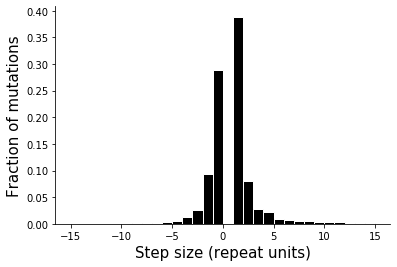

In [46]:
print("All (excluding homopolymers)")

fig = plt.figure()
ax = fig.add_subplot(111)

plotdata = adata[(adata.chrom!="X") & (adata["period"]>1)]
ax.hist(plotdata["mutsize"], color="black", edgecolor="white", bins=bins,
       weights=np.zeros_like(plotdata["mutsize"]) + 1. / plotdata["mutsize"].size);

ax.set_xlabel("Step size (repeat units)", size=15)
ax.set_ylabel("Fraction of mutations", size=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "Figure2_StepSize-All.pdf"))

#### Binom Test
BinomTest(plotdata)

# SuppFig: step size by parental origin

Father (excluding homopolymers)
n= 26248
expansions=0.50
contractions=0.50
Binomial pval=0.7906927940458632


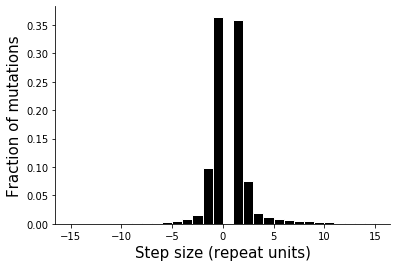

In [47]:
#### FATHER
print("Father (excluding homopolymers)")
fig = plt.figure()
ax = fig.add_subplot(111)

plotdata = adata[(adata.chrom!="X") & (adata["period"]>1) & (adata["poocase"]==2)].copy()
ax.hist(plotdata["mutsize"], color="black", edgecolor="white", bins=bins,
       weights=np.zeros_like(plotdata["mutsize"]) + 1. / plotdata["mutsize"].size);

ax.set_xlabel("Step size (repeat units)", size=15)
ax.set_ylabel("Fraction of mutations", size=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "SuppFig_StepSize-FATHER.pdf"))

#### Binom Test
BinomTest(plotdata)

Mother (excluding homopolymers)
n= 9061
expansions=0.57
contractions=0.43
Binomial pval=2.1740424167128623e-39


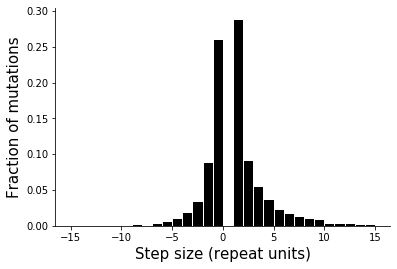

In [48]:
#### MOTHER 
print("Mother (excluding homopolymers)")
fig = plt.figure()
ax = fig.add_subplot(111)

plotdata = adata[(adata.chrom!="X") & (adata["period"]>1) & (adata["poocase"]==3)].copy()
ax.hist(plotdata["mutsize"], color="black", edgecolor="white", bins=bins,
       weights=np.zeros_like(plotdata["mutsize"]) + 1. / plotdata["mutsize"].size);

ax.set_xlabel("Step size (repeat units)", size=15)
ax.set_ylabel("Fraction of mutations", size=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "SuppFig_StepSize-MOTHER.pdf"))

#### Binom Test
BinomTest(plotdata)

# Two proportion z-test

In [49]:
#### Testing proportion of expansions from mothers vs. fathers 
#### two tailed proportion test p = (p1 * n1 + p2 * n2) / (n1 + n2)
nfat = len(adata[(adata.chrom!="X") & (adata["period"]>1) & (adata["poocase"]==2)])
nmat = len(adata[(adata.chrom!="X") & (adata["period"]>1) & (adata["poocase"]==3)])
fat = adata[(adata["period"]>1) & (adata["poocase"]==2)] 
pfat = sum(fat["mutsize"]>0)/len(fat.mutsize)
mat = adata[(adata["period"]>1) & (adata["poocase"]==3)] 
pmat = sum(mat["mutsize"]>0)/len(mat.mutsize)
p = ((pfat*nfat) + (pmat*nmat)) / (nfat+nmat)

print("Father: ", "proportion=",pfat, "n=", nfat)
print("Mother: ", "proportion=",pmat, "n=", nmat)

#### SE = sqrt{ p * ( 1 - p ) * [ (1/n1) + (1/n2) ] }
se = np.sqrt(p * (1-p) * ((1/nfat) + 1/nmat))

#### z = (p1 - p2) / SE
z = (pfat - pmat) / se
# print(z)

#### p-value
p_value = scipy.stats.norm.sf(abs(z))*2 #twosided
print("p-val=",p_value)

Father:  proportion= 0.4997366044551475 n= 26248
Mother:  proportion= 0.5625458739645591 n= 9061
p-val= 6.033469315359162e-25
